In [1]:
#Import Libraries
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from utils import read_yaml
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from mlflow.models import infer_signature
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlflow.data.pandas_dataset import PandasDataset
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import (roc_curve, roc_auc_score, 
                            classification_report, accuracy_score, 
                            precision_score, recall_score, 
                            f1_score)


In [2]:
train = pd.read_csv('data/train1.csv')
test = pd.read_csv('data/test1.csv')

In [3]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.333333,0.0,0.044302,0.066667,0.800000,1.000000,0.285714,0.8,1.0,0.0,0.02174,0.0,0.397959,1.0,0.0
1,0.333333,0.0,0.048238,0.066667,0.800000,0.666667,0.071429,0.2,1.0,0.0,0.00000,0.0,0.122449,1.0,0.0
2,0.333333,1.0,0.138113,0.000000,0.533333,0.333333,0.642857,0.8,1.0,0.0,0.00000,0.0,0.397959,1.0,0.0
3,0.333333,1.0,0.151068,0.866667,0.400000,0.666667,0.642857,0.2,0.0,0.0,0.00000,0.0,0.397959,1.0,0.0
4,0.000000,1.0,0.221488,0.066667,0.800000,0.666667,0.142857,0.6,0.0,1.0,0.00000,0.0,0.397959,0.0,0.0


In [4]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.000000,1.0,0.144430,0.866667,0.400000,1.000000,0.214286,1.0,0.0,0.0,0.000000,0.0,0.397959,1.0,0.0
1,0.333333,1.0,0.051677,0.000000,0.533333,0.666667,0.285714,0.2,1.0,0.0,0.000000,0.0,0.500000,1.0,0.0
2,0.000000,0.0,0.219011,0.400000,0.733333,0.666667,0.428571,0.2,1.0,0.0,0.000000,0.0,0.397959,1.0,1.0
3,0.333333,1.0,0.099418,0.133333,0.600000,0.666667,0.214286,0.2,0.0,0.0,0.076881,0.0,0.397959,1.0,1.0
4,0.000000,0.0,0.060942,0.133333,0.600000,1.000000,0.714286,1.0,1.0,1.0,0.000000,0.0,0.295918,1.0,0.0


In [5]:
#X_train = train.drop('income', axis = 1)
X_train = train.drop(['income'], axis = 1)

In [6]:
#X_test = test.drop('income', axis = 1)
X_test = test.drop(['income'], axis = 1)

In [7]:
y_train = train['income']
y_test = test['income']

In [8]:
#undersampling the train set
under = OneSidedSelection()
X_train_usample, y_train_usample = under.fit_resample(X_train, train['income'])


#oversampling the train set
sm = SMOTE()
X_train_osample, y_train_osample = sm.fit_resample(X_train_usample, y_train_usample)

X_train = pd.DataFrame(X_train_osample, columns=train.drop(['income'], axis=1).columns)



#creating the final train 
X_train = pd.concat([X_train, y_train_osample], axis=1)

In [9]:
X_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.000000,1.0,0.057742,0.066667,0.800000,1.000000,0.285714,0.8,1.0,1.0,0.00000,0.0,0.479592,1.0,0.0
1,0.333333,0.0,0.044302,0.066667,0.800000,1.000000,0.285714,0.8,1.0,0.0,0.02174,0.0,0.397959,1.0,0.0
2,0.333333,0.0,0.048238,0.066667,0.800000,0.666667,0.071429,0.2,1.0,0.0,0.00000,0.0,0.122449,1.0,0.0
3,0.333333,1.0,0.138113,0.000000,0.533333,0.333333,0.642857,0.8,1.0,0.0,0.00000,0.0,0.397959,1.0,0.0
4,0.000000,1.0,0.221488,0.066667,0.800000,0.666667,0.142857,0.6,0.0,1.0,0.00000,0.0,0.397959,0.0,0.0


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45780 entries, 0 to 45779
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45780 non-null  float64
 1   workclass       45780 non-null  float64
 2   fnlwgt          45780 non-null  float64
 3   education       45780 non-null  float64
 4   education_num   45780 non-null  float64
 5   marital_status  45780 non-null  float64
 6   occupation      45780 non-null  float64
 7   relationship    45780 non-null  float64
 8   race            45780 non-null  float64
 9   sex             45780 non-null  float64
 10  capital_gain    45780 non-null  float64
 11  capital_loss    45780 non-null  float64
 12  hours_per_week  45780 non-null  float64
 13  native_country  45780 non-null  float64
 14  income          45780 non-null  float64
dtypes: float64(15)
memory usage: 5.2 MB


In [11]:
y_train = X_train['income']
X_train.drop(['income', 'fnlwgt', 'race', 'education'], inplace=True, axis=1)

In [12]:
X_test.drop(['fnlwgt', 'race', 'education'], inplace=True, axis=1)

In [13]:
X_train

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.000000,1.0,0.800000,1.000000,0.285714,0.800000,1.0,0.000000,0.000000,0.479592,1.0
1,0.333333,0.0,0.800000,1.000000,0.285714,0.800000,0.0,0.021740,0.000000,0.397959,1.0
2,0.333333,0.0,0.800000,0.666667,0.071429,0.200000,0.0,0.000000,0.000000,0.122449,1.0
3,0.333333,1.0,0.533333,0.333333,0.642857,0.800000,0.0,0.000000,0.000000,0.397959,1.0
4,0.000000,1.0,0.800000,0.666667,0.142857,0.600000,1.0,0.000000,0.000000,0.397959,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45775,0.333333,1.0,0.866667,0.666667,0.071429,0.200000,0.0,0.150242,0.000000,0.662818,1.0
45776,0.333333,1.0,0.800000,0.666667,0.128443,0.200000,0.0,0.000000,0.436639,0.500000,1.0
45777,0.333333,0.0,1.000000,0.666667,0.142857,0.200000,0.0,0.026547,0.000000,0.500000,1.0
45778,0.333333,1.0,0.548154,0.407438,0.071429,0.755537,1.0,0.000000,0.500196,0.397959,1.0


In [14]:
X_test.head()

,age,workclass,education_num,marital_status,occupation,relationship,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.000000,1.0,0.400000,1.000000,0.214286,1.0,0.0,0.000000,0.0,0.397959,1.0
1,0.333333,1.0,0.533333,0.666667,0.285714,0.2,0.0,0.000000,0.0,0.500000,1.0
2,0.000000,0.0,0.733333,0.666667,0.428571,0.2,0.0,0.000000,0.0,0.397959,1.0
3,0.333333,1.0,0.600000,0.666667,0.214286,0.2,0.0,0.076881,0.0,0.397959,1.0
4,0.000000,0.0,0.600000,1.000000,0.714286,1.0,1.0,0.000000,0.0,0.295918,1.0


In [15]:
y_train.value_counts()

0.0    22890
1.0    22890
Name: income, dtype: int64

In [16]:
configbox = read_yaml('params.yaml')
xgb_params = configbox.XGBOOST

yaml file: params.yaml loaded successfully


In [17]:
xgb_params

ConfigBox({'n_estimators': 128, 'learning_rate': 0.1, 'max_depth': 6})

### XGB

In [18]:
xgb_classifier = xgb.XGBClassifier(n_estimators = xgb_params.n_estimators,
                                   learning_rate = xgb_params.learning_rate,
                                  max_depth = xgb_params.max_depth)

In [19]:
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_pred_train = xgb_classifier.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
print(accuracy_train)

0.8968233074459216


In [20]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test,y_pred)

metrics = {'Precision': precision, 'Recall': recall, 'f1_score': f_score, 'AUC': auc, 'accuracy': accuracy}

In [21]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df 

,precision,recall,f1-score,support
0.0,0.928197,0.826458,0.874378,12435.000000
1.0,0.585717,0.793292,0.673882,3846.000000
accuracy,0.818623,0.818623,0.818623,0.818623
macro avg,0.756957,0.809875,0.774130,16281.000000
weighted avg,0.847294,0.818623,0.827015,16281.000000


In [22]:
print(classification_report(y_train,y_pred_train))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89     22791
         1.0       0.88      0.92      0.90     22791

    accuracy                           0.90     45582
   macro avg       0.90      0.90      0.90     45582
weighted avg       0.90      0.90      0.90     45582

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.87     12435
         1.0       0.59      0.79      0.67      3846

    accuracy                           0.82     16281
   macro avg       0.76      0.81      0.77     16281
weighted avg       0.85      0.82      0.83     16281



In [23]:
xgboost_auc=roc_auc_score(y_test,y_pred)
r_probs = [0 for _ in range(len(y_test))]
random_auc = roc_auc_score(y_test, r_probs)
print(xgboost_auc)
print(random_auc)

0.8098746555411072
0.5


In [24]:
probs = xgb_classifier.predict_proba(X_test)
# Keep probabilities for one class
probs = probs[:,1]

# Get false and True positive rate
r_fpr, r_tpr, _ = roc_curve(y_test,probs)
x = np.arange(0,1.01,0.01)

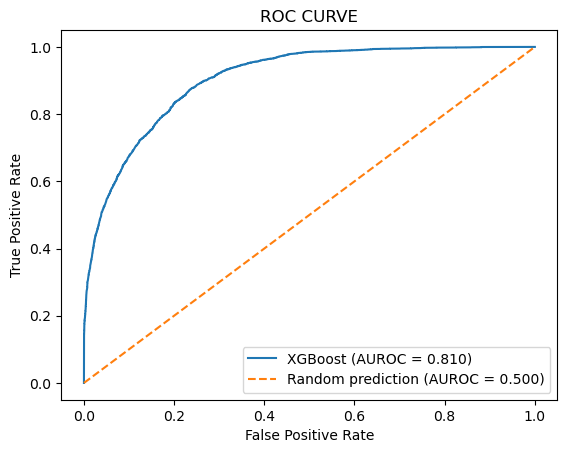

In [25]:
plt.plot(r_fpr, r_tpr, label='XGBoost (AUROC = %0.3f)' % xgboost_auc)
plt.plot(x,x, linestyle='--', label='Random prediction (AUROC = %0.3f)' % random_auc)
plt.legend()
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig(f'visualization/roc_curve{xgboost_auc}.png')
plt.show()

In [26]:
# Construct an MLflow PandasDataset from the Pandas DataFrame, and specify the source
train_dataset: PandasDataset = mlflow.data.from_pandas(train, source= 'data/train1.csv')
# test
test_dataset: PandasDataset = mlflow.data.from_pandas(test, source= 'data/test1.csv')

C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [27]:

mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("XGBOOST EXPERIMENTS")

with mlflow.start_run() as run:
    mlflow.log_params(xgb_params)
    mlflow.log_metrics(metrics)
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Some Columns", "no race, education, fnlwgt undersampling and over sampling")
    
    # Log the dataset to the MLflow Run. Specify the "training" context to indicate that the
    # dataset is used for model training
    mlflow.log_input(train_dataset, context="training")
    mlflow.log_input(test_dataset, context = "testing")
    mlflow.log_artifact(f'visualization/roc_curve{xgboost_auc}.png')

    
    # Infer the model signature
    signature = infer_signature(X_train, y_pred_train)
    
    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model= xgb_classifier,
        artifact_path = "income_class",
        signature = signature,
        input_example = X_train,
        registered_model_name = "xgboost",
    )


C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\xgboost\core.py:160: UserWarning: [13:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'xgboost' already exists. Creating a new version of this model...
2024/03/21 13:06:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 10
Created version '10' of model 'xgboost'.


In [29]:
import requests
import pandas as pd  # Make sure you have pandas installed

# Assuming X_test is a pandas DataFrame
lst = X_test[:10].to_dict(orient="records")  # Convert DataFrame to a list of dictionaries
inference_request = {
    "inputs": lst
}
endpoint = "http://localhost:1234/invocations"
response = requests.post(endpoint, json=inference_request)

if response.status_code == 200:
    print("Inference successful!")
    print(response.json())
else:
    print(f"Error: {response.status_code} - {response.text}")


Inference successful!
{'predictions': [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]}


In [30]:
y_test[:10]

0    0.0
1    0.0
2    1.0
3    1.0
4    0.0
5    0.0
6    0.0
7    1.0
8    0.0
9    0.0
Name: income, dtype: float64

## DNN

In [28]:
num_train_examples, input_dim = X_train.shape
input_dim

11

In [44]:
batch_size = 128
num_train_examples, input_dim = X_train.shape
# Number of times to pass through data
num_epcohs = 20

input = tf.keras.Input(shape=(11,))
#x = tf.keras.layers.concatenate(input)
x = tf.keras.layers.Dense(100, activation='relu', kernel_initializer= 'uniform')(input)
x = tf.keras.layers.Dense(75, activation='relu')(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
x = tf.keras.layers.Dense(25, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs = input, outputs= output)

In [45]:
learning_rate = .01

# Optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
# Compile Keras model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [46]:
# Setup Learning Rate decay.
lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: learning_rate + 0.02 * (0.5 ** (1 + epoch)),
    verbose=True
)

In [48]:
model.fit(
    X_train,
    y_train,
    epochs = num_epcohs,
    batch_size= 128,
    steps_per_epoch=int(num_train_examples / batch_size),
    callbacks = [lr_decay_cb]  
)



Epoch 1: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/20
357/357 [==============================] - 2s 4ms/step - loss: 0.3942 - accuracy: 0.8198 - lr: 0.0200

Epoch 2: LearningRateScheduler setting learning rate to 0.015.
Epoch 2/20
357/357 [==============================] - 1s 4ms/step - loss: 0.3713 - accuracy: 0.8320 - lr: 0.0150

Epoch 3: LearningRateScheduler setting learning rate to 0.0125.
Epoch 3/20
357/357 [==============================] - 1s 3ms/step - loss: 0.3628 - accuracy: 0.8369 - lr: 0.0125

Epoch 4: LearningRateScheduler setting learning rate to 0.01125.
Epoch 4/20
357/357 [==============================] - 1s 4ms/step - loss: 0.3595 - accuracy: 0.8382 - lr: 0.0113

Epoch 5: LearningRateScheduler setting learning rate to 0.010625.
Epoch 5/20
357/357 [==============================] - 1s 4ms/step - loss: 0.3567 - accuracy: 0.8401 - lr: 0.0106

Epoch 6: LearningRateScheduler setting learning rate to 0.0103125.
Epoch 6/20
357/357 [======================

In [50]:
y_pred = model.predict(X_test)

509/509 [==============================] - 1s 3ms/step


In [90]:
classes = y_pred > 0.5

In [91]:
accuracy_score(y_test, classes)

0.7873594988022848

In [92]:
roc_auc_score(y_test, classes)

0.8132042000618505

In [93]:
f1_score(y_test, classes)

0.657023974638399

In [58]:
r_probs = [0 for _ in range(len(y_test))]
random_auc = roc_auc_score(y_test, r_probs)
#print(xgauc)
print(random_auc)

0.5


In [2]:
# Set tracking uri
mlflow.set_tracking_uri('http://localhost:5000')

# Get the model uri you need
model_uri = 'runs:/97c3446b013742c6988f0ab7eeb5f304/income_class'

In [3]:
# Load the model using mlflow.xgboost.load_model
loaded_model = mlflow.xgboost.load_model(model_uri)

In [5]:

# While not directly recommended for deployment due to limitations,
# you can use pickle for temporary use or exploration (avoid for production)
# But I will be using it here
import pickle
with open("income-pred/app/income.pkl", "wb") as f:
    pickle.dump(loaded_model, f)

### Random Forest

In [ ]:
rf=RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
import mlflow
from mlflow.models import infer_signature

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("XGBOOST EXPERIMENTS")

with mlflow.start_run() as run:
    mlflow.log_params(rf_params)
    mlflow.log_metrics(rf_metrics)
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("")
    
    # Infer the model signature
    signature = infer_signature(X_train, y_pred_train)
    
    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model= xgb_classifier,
        artifact_path = "income_class",
        signature = signature,
        input_example = X_train,
        registered_model_name = "random_forest",
    )


In [ ]:
import mlflow

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")